In [1]:
import qctoolkit as qtk
from matplotlib import pyplot as plt
import qmnet_model as qnm
import qmnet_tools as qnt
import tensorflow as tf
import re
import numpy as np
import qmnet_layer as qnl
import qmnet_analysis as qna

%matplotlib inline

In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 128

In [3]:
molstr_list = [
    'HH',
    'HHe+',
    'HLi',
    'HBe+',
    'HeHe',
    'HeLi+',
    'HeBe',
    'LiLi',
    'LiBe+',
    'BeBe',
]

In [4]:
def get_inp_grp(molstr_list, resolution):
    inp_grp = []
    #inp_dump = []
    for molstr in molstr_list:
        if '+' in molstr:
            charge = 1
        elif '-' in molstr:
            charge = -1
        else:
            charge = 0
        alist = re.findall('[A-Z][a-z]*', molstr)
        Zs = [qtk.n2Z(a) for a in alist]
        inp_list = []
        inp_grp.append(inp_list)
        #inp_dump.append(inp_list)
        res = resolution
        for R in np.arange(0.3, 4.0 + res, res):
            mol = qtk.Molecule()
            ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
            mol.build(ZR)
            mol.charge = charge
            mol.name = mol.name + '_%s' % str(R)
            inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
            try:
                inp.run()
                D, U = np.linalg.eigh(inp.olp)
                inp.X = U / np.sqrt(D)

                # to save inps into pickle file
                #inp.delete_ht_types()
                #inp.delete_matrices()

                inp_list.append(inp)
            except:
                pass
        print "%s finished" % mol.name
    print [len(inp) for inp in inp_grp]
    return inp_grp

In [5]:
inp_grp = get_inp_grp(molstr_list, resolution=0.005)

H2_4.0 finished
H1He1_4.0 finished
H1Li1_4.0 finished
H1Be1_4.0 finished
He2_4.0 finished
He1Li1_4.0 finished
He1Be1_4.0 finished
Li2_4.0 finished
Li1Be1_4.0 finished
Be2_4.0 finished
[741, 741, 741, 563, 741, 741, 741, 741, 741, 741]


In [6]:
inp_grp_dense = get_inp_grp(molstr_list, resolution=0.001)

H2_4.001 finished
H1He1_4.001 finished
H1Li1_4.001 finished
H1Be1_4.001 finished
He2_4.001 finished
He1Li1_4.001 finished
He1Be1_4.001 finished
Li2_4.001 finished
Li1Be1_4.001 finished
Be2_4.001 finished
[3702, 3702, 3702, 2814, 3702, 3702, 3702, 3702, 3702, 3702]


In [81]:
reload(qna)
get_C_prd = qna.get_C_prd
learningCurve = qna.learningCurve
def get_model_plot(qm_model, file_root, loss='energy', mol_ind=0, train_list=None, sample_step=10):
    
    if train_list is None:
        train_list = [mol_ind]
        file_root = molstr_list[mol_ind].replace('+','') + "_" + file_root
    
    inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, mol_ind, train_list)
    model_root = '%s_%s' % (file_root, loss)
    
    save_root = model_root + '_%d' % sample_step
    model_file = "%s.ckpt" % model_root
    model_hist = "%s_hist.pkl" % model_root
    
    ################
    # LOAD HISTORY #
    ################
    C_tar, E_tar = get_C_prd(qm_model, model_file, inp_train)
    C_prd, E_prd = get_C_prd(qm_model, model_file, inp_test)
    C_val, E_val = get_C_prd(qm_model, model_file, inp_valid)

    # [train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist]
    opt_hist = qtk.load(model_hist)
    C_hist = np.array(opt_hist[-3])
    
    ############################
    # BINDING CURVE PREDICTION #
    ############################
    C_start = C_hist[1]
    C_mid = C_hist[50]
    C_end = C_hist[-1]

    E_prd_start = []
    E_prd_mid = []
    E_prd_end = []
    for i in range(len(inp_valid)):
        inp = inp_valid[i]
        Cs = C_start[i]
        Cm = C_mid[i]
        Ce = C_end[i]
        E_prd_start.append(qna.energy(inp, Cs))
        E_prd_mid.append(qna.energy(inp, Cm))
        E_prd_end.append(qna.energy(inp, Ce))

    E_prd_start = np.array(E_prd_start)
    E_prd_mid = np.array(E_prd_mid)
    E_prd_end = np.array(E_prd_end)
    
    #######################
    # LEARNING CURVE DATA #
    #######################
    def _calculate_data():
        hist_x = range(len(opt_hist[2]))[::sample_step]
        learn_E = learningCurve(qna.energy, inp_valid, C_hist, hist_ind=hist_x)
        learn_eigs = learningCurve(qna.eigenvalues, inp_valid, C_hist, hist_ind=hist_x)
        learn_fe = learningCurve(qna.fockError, inp_valid, C_hist, hist_ind=hist_x)
        learn_dme = learningCurve(qna.dmError, inp_valid, C_hist, hist_ind=hist_x, diff=False)
        learn_drho = learningCurve(qna.dRho, inp_valid, C_hist, hist_ind=hist_x, diff=False)
        learn_dpsi = learningCurve(qna.dPsi, inp_valid, C_hist, hist_ind=hist_x, diff=False)
        
        np.savez(save_root+'_lc.npz', x=hist_x, E=learn_E, eigs=learn_eigs, fe=learn_fe, 
                 dme=learn_dme, drho=learn_drho, dpsi=learn_dpsi)
        
        return hist_x, learn_E, learn_eigs, learn_fe, learn_dme, learn_drho, learn_dpsi
    def _load_data():
        data = np.load(save_root + '_lc.npz')
        hist_x = data['x']
        learn_E = data['E']
        learn_eigs = data['eigs']
        learn_fe = data['fe']
        learn_dme = data['dme']
        learn_drho = data['drho']
        learn_dpsi = data['dpsi']
        return hist_x, learn_E, learn_eigs, learn_fe, learn_dme, learn_drho, learn_dpsi
    
    try:
        hist_x, learn_E, learn_eigs, learn_fe, learn_dme, learn_drho, learn_dpsi = _load_data()
    except:
        hist_x, learn_E, learn_eigs, learn_fe, learn_dme, learn_drho, learn_dpsi = _calculate_data()
    
    #############
    # MAKE PLOT #
    #############
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(12,9))

    ax1.plot(R_val, E_prd_start, ls='', marker='.', ms=5, label='step 2')
    ax1.plot(R_val, E_prd_mid, ls='', marker='.', ms=2, label='step 50')
    ax1.plot(R_val, E_prd_end, ls='', marker='.', ms=1, label='last step')
    #ax1.set_ylim(-8,-7)
    ax1.legend(fontsize=15)

    ax2.loglog(hist_x, learn_E, label=r'|$\Delta E_{\mathbf{HF}}|$')
    for i in range(4):
        ax2.loglog(hist_x, learn_eigs[:,i], ls='--', label=r'$|\Delta\varepsilon_%d|$' % (i+1))
    ax2.legend(fontsize=15, loc=3)

    ax4.loglog(hist_x, learn_drho, label=r'$\int|\Delta\rho|$')
    for i in range(4):
        ax4.loglog(hist_x, learn_dpsi[:,i], ls='--', label=r'$\int|\Delta\psi_%d|$' % (i+1))
    ax4.legend(loc=3, fontsize=15)

    ax3.loglog(hist_x, learn_fe, label=r'$|\Delta\mathbf{H}|$')
    ax3.loglog(hist_x, learn_dme, ls=':', label=r'$|\Delta\mathbf{P}|$')
    ax3.legend(fontsize=15)

    ax1.set_xlabel(r'$R$ [$\mathrm{\AA}$]', fontsize=15)
    ax2.set_xlabel('# step', fontsize=15)
    ax3.set_xlabel('# step', fontsize=15)
    ax4.set_xlabel('# step', fontsize=15)

    ax1.set_ylabel(r'$E_{\mathrm{HF}}$ [Ha]', fontsize=15)
    ax2.set_ylabel(r'[Ha]', fontsize=15)
    
    plt.tight_layout()
    fig.savefig(save_root+'_plot.pdf')

INFO:tensorflow:Restoring parameters from HH_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_fock.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_fock.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_fock.ckpt
INFO:tensorflow:Restoring parameters from HLi_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HLi_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HLi_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HLi_SCF_single_test_emin.ckpt
INFO:tensorflow:Restoring parameters from HLi_SCF_single_test

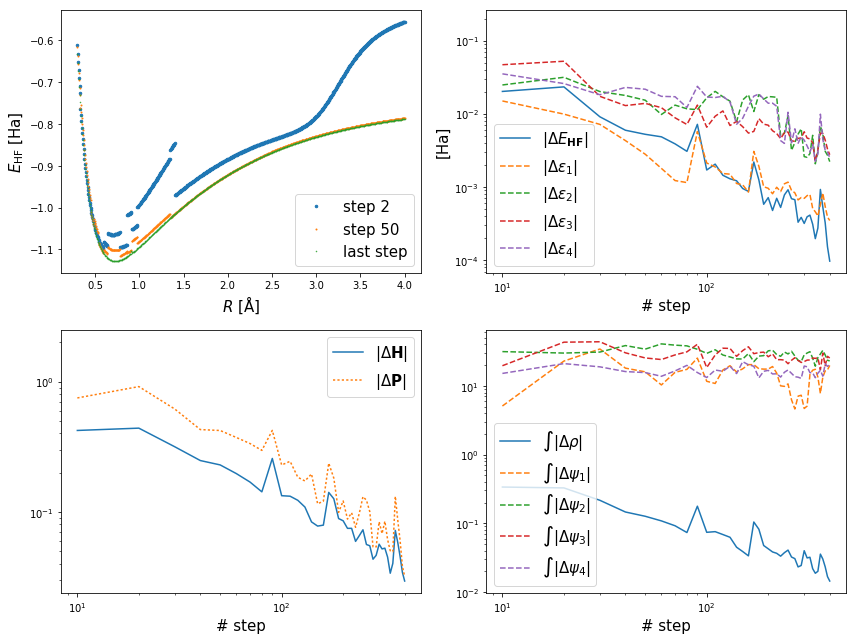

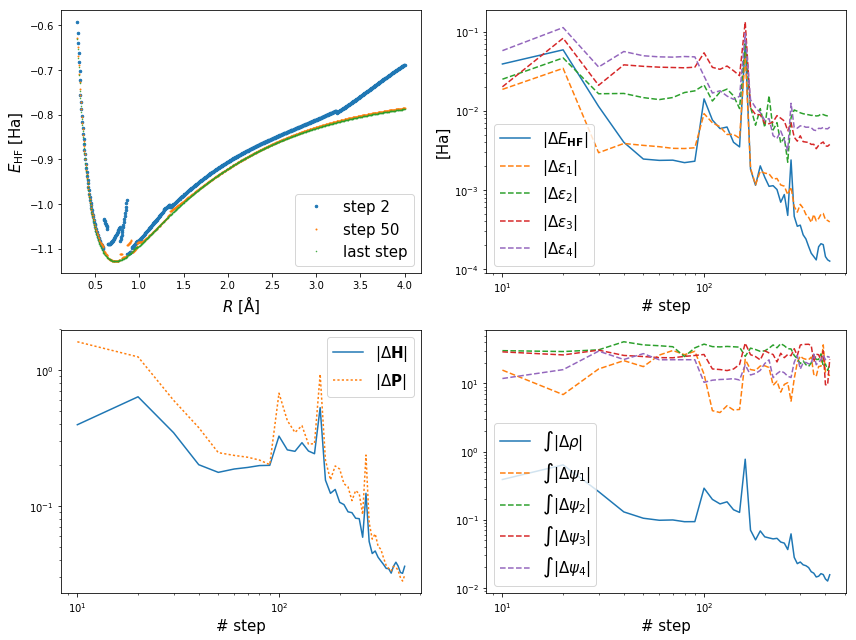

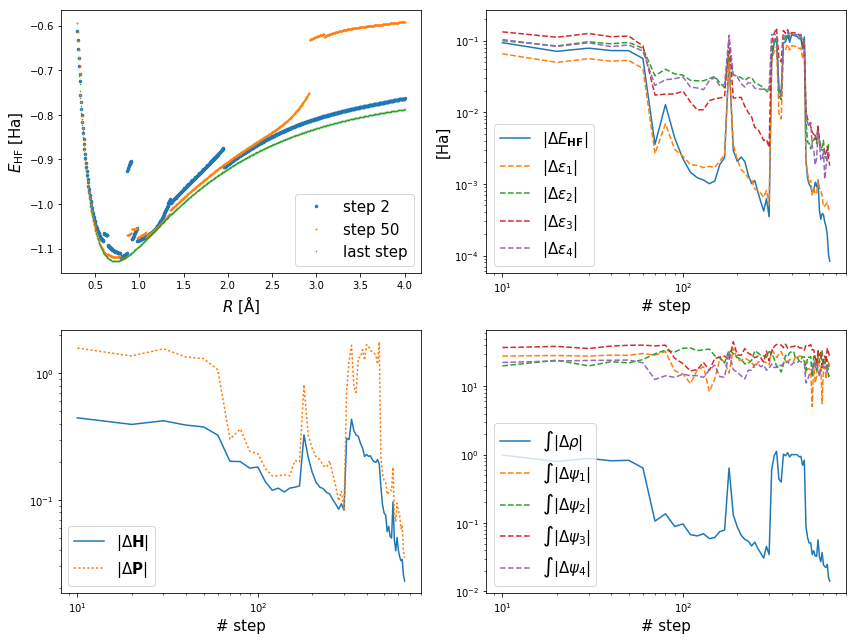

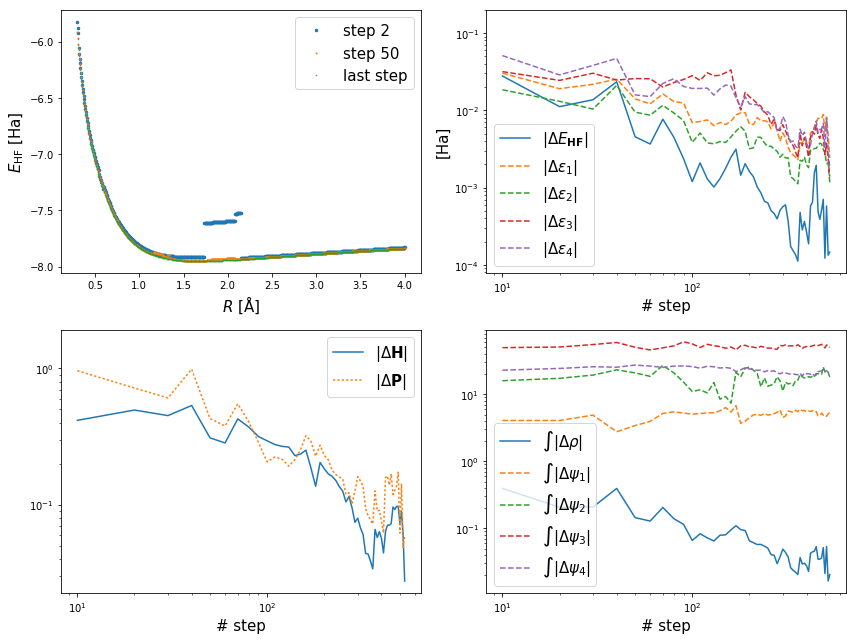

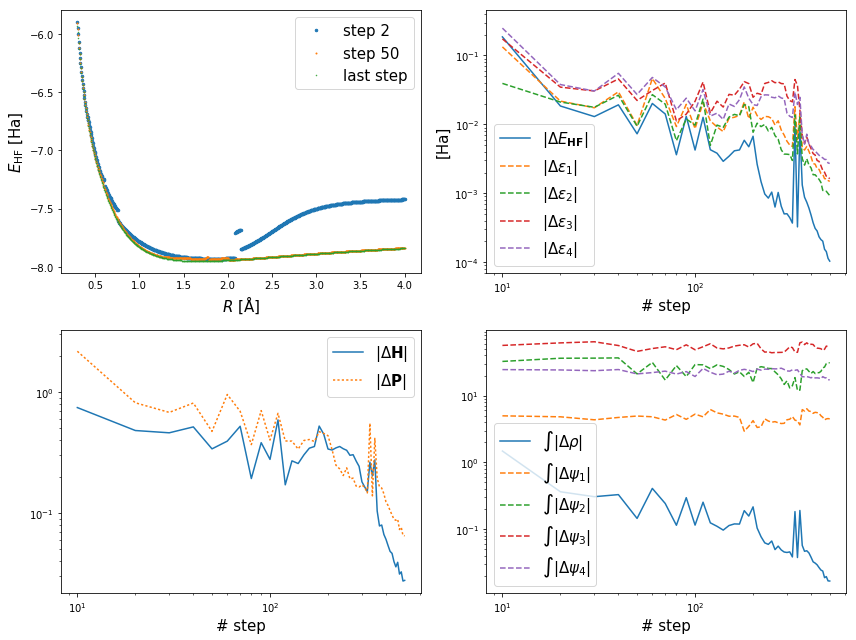

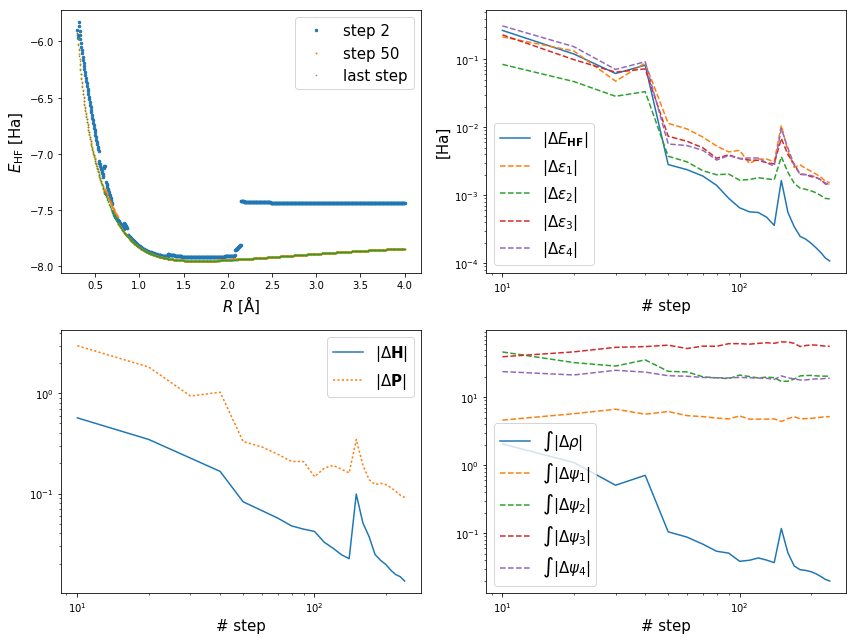

In [82]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)
qm_model = qnm.I0_S1x4_O2_SCFx1

get_model_plot(qm_model, 'SCF_single_test', 'energy', sample_step=10)
get_model_plot(qm_model, 'SCF_single_test', 'emin', sample_step=10)
get_model_plot(qm_model, 'SCF_single_test', 'fock', sample_step=10)

get_model_plot(qm_model, 'SCF_single_test', 'energy', 2, sample_step=10)
get_model_plot(qm_model, 'SCF_single_test', 'emin', 2, sample_step=10)
get_model_plot(qm_model, 'SCF_single_test', 'fock', 2, sample_step=10)

INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_energy.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_energy.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_energy.ckpt
processing <function energy at 0x7f714f7e1e60>
processing <function eigenvalues at 0x7f71ba1d1b18>
processing <function fockError at 0x7f71b5654578>
processing <function dmError at 0x7f717fbbe0c8>
processing <function dRho at 0x7f7191593e60>
processing <function dPsi at 0x7f71b5688c08>
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
processing <function energy at 0x7f714f7e1e60>
processing <function eigenvalues at 0x7f71ba1d1b18>
processing <function fockError at 0x7f71b5654578>
processing <function dmError at 0x7f717fbbe0c8>
processing <function dRho at 0x7f7191593e60>
processing <function dPsi at 0x7f71b5688c08>
INFO:tensorflow:Restoring para

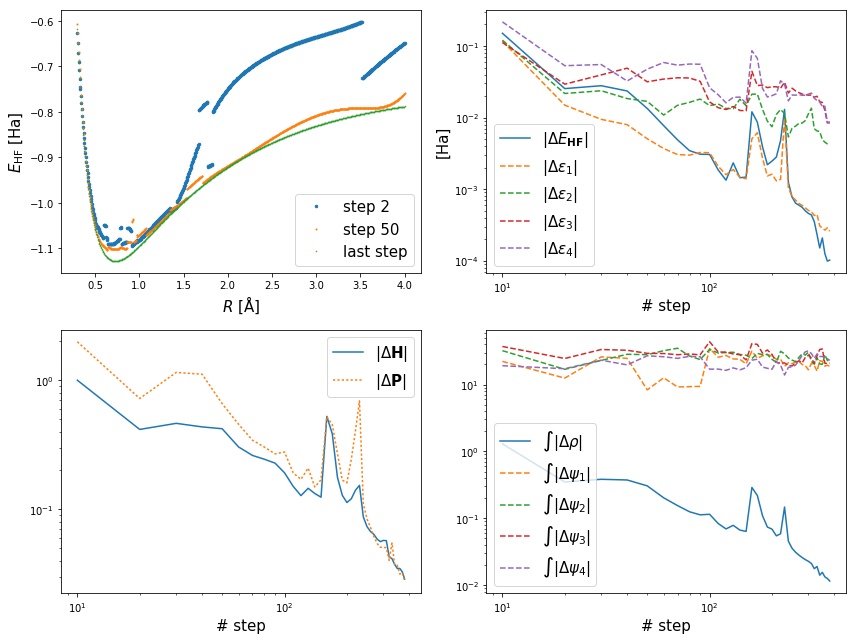

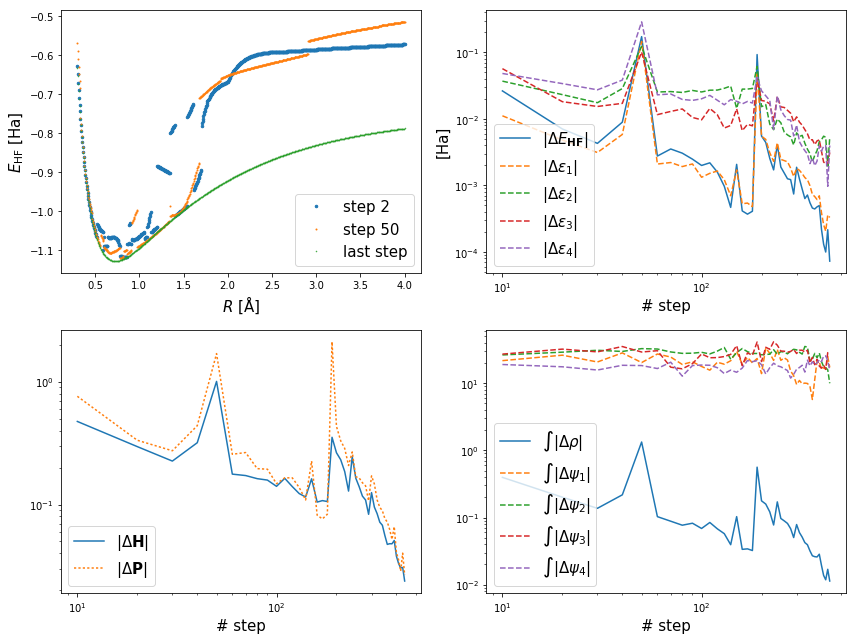

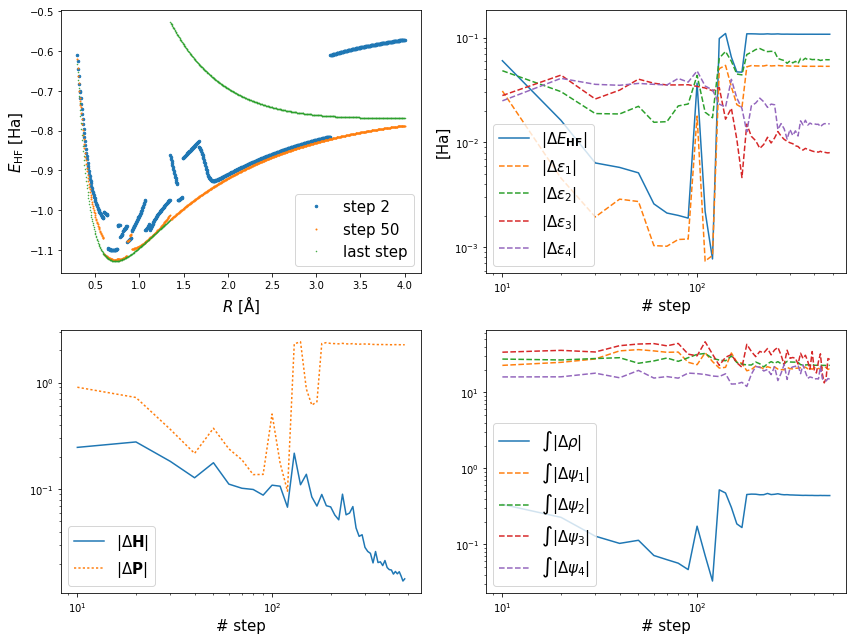

In [86]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)
qm_model = qnm.I0_S1x4_O3_SCFx1


get_model_plot(qm_model, 'S4_O3_SCF', 'energy', 0, sample_step=10)
get_model_plot(qm_model, 'S4_O3_SCF', 'emin', 0, sample_step=10)
get_model_plot(qm_model, 'S4_O3_SCF', 'fock', 0, sample_step=10)

# Contour plots

In [6]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)

get_C_prd = qna.get_C_prd
learningCurve = qna.learningCurve

mol_ind = 0
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, mol_ind, [mol_ind])

qm_model = qnm.I0_S1x4_O2_SCFx1
model_root = "%s_S4_O3_SCF_emin" % molstr_list[mol_ind].replace('+','')
model_file = "%s.ckpt" % model_root
model_hist = "%s_hist.pkl" % model_root

In [7]:
C_tar, E_tar = get_C_prd(qm_model, model_file, inp_train)
C_prd, E_prd = get_C_prd(qm_model, model_file, inp_test)
C_val, E_val = get_C_prd(qm_model, model_file, inp_valid)

# [train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist]
opt_hist = qtk.load(model_hist)
C_hist = np.array(opt_hist[-3])
print 'done'

INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
done


In [30]:
inps = inp_grp[0]
inds = qnt.validation_inds(inps)[:3]

#fix, axarr = plt.subplots(2, 3, figsize=(16,12))

q_tar_list = []
q_prd_list = []
for i in inds:
    inp = inps[i]
    print inp.molecule.R[1,0]
    q_tar_list.append(inp.getRhoCube())
    q_prd_list.append(inp.getRhoCube(dm=inp.dm(C_hist[-1,i])))

0.515
0.73
2.365


CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 
CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 


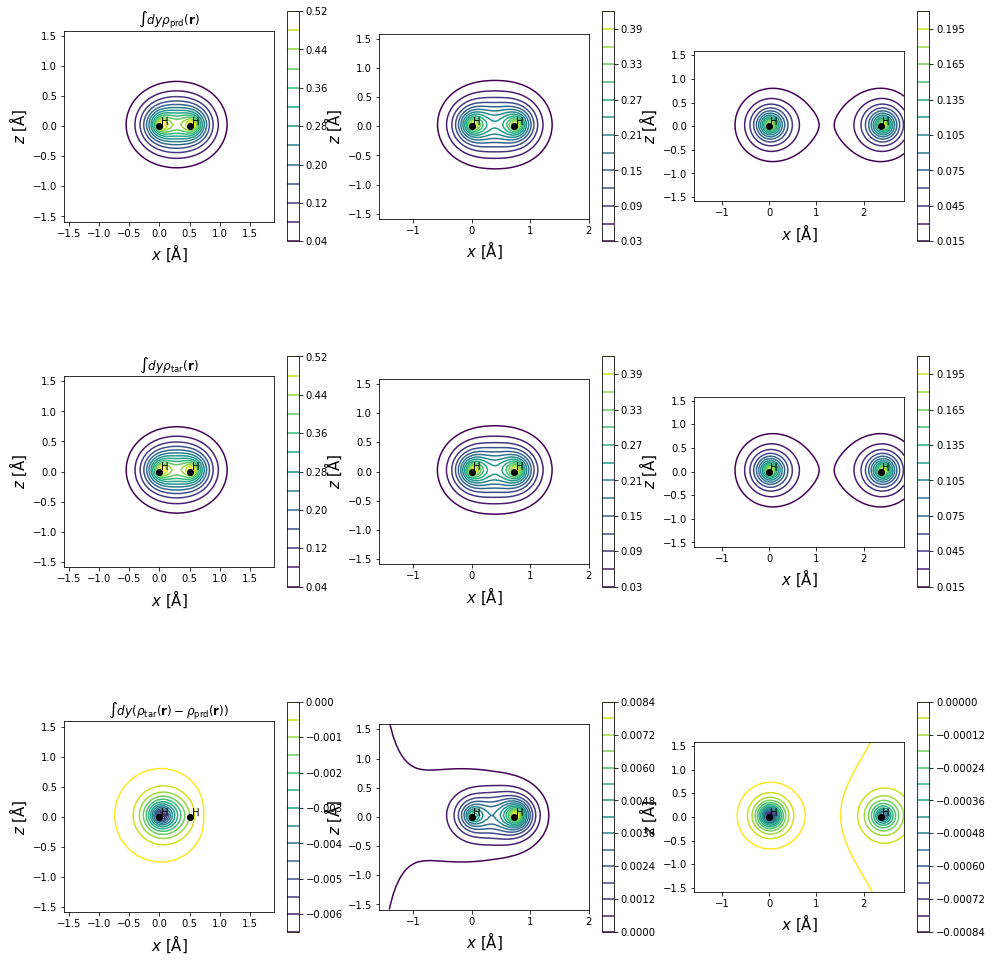

In [28]:
fig, axarr = plt.subplots(3, 3, figsize=(16,18))

vmaxs = [0.52, 0.4, 0.2]

for i in range(3):
    pltkw = {'vmax': vmaxs[i], 'vmin':0}
    q_prd_list[i].contour(axis=1, ax=axarr[0,i], fig=fig, colorbar=True, pltkwargs=pltkw)
    q_tar_list[i].contour(axis=1, ax=axarr[1,i], fig=fig, colorbar=True, pltkwargs=pltkw)
    q_diff = q_tar_list[i] - q_prd_list[i]
    q_diff.contour(axis=1, ax=axarr[2,i], fig=fig, colorbar=True, pltkwargs=pltkw)
axarr[0,0].set_title(r'$\int dy\rho_{\mathrm{prd}}(\mathbf{r})$')
axarr[1,0].set_title(r'$\int dy\rho_{\mathrm{tar}}(\mathbf{r})$')
axarr[2,0].set_title(r'$\int dy(\rho_{\mathrm{tar}}(\mathbf{r}) - \rho_{\mathrm{prd}}(\mathbf{r}))$')

CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 


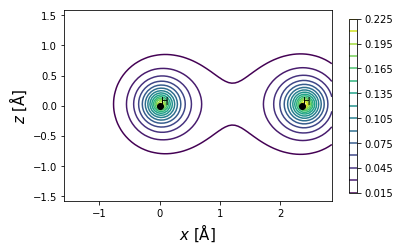

In [17]:
q_prd.contour(axis=1)
pass

In [87]:
C_hist.shape

(403, 741, 4, 4)

# indevidual property analysis

In [6]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)

get_C_prd = qna.get_C_prd
learningCurve = qna.learningCurve

mol_ind = 0
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, mol_ind, [mol_ind])
#_, _, inp_dense = qnt.train_test_valid(inp_grp, valid_ind, train_list)

#qm_model = qnm.I0_S1x2_d_S1x2_O1x3_SCF
qm_model = qnm.I0_S1x4_O2_SCFx1
model_root = '%s_SCF_single_test_energy' % molstr_list[mol_ind].replace('+','')
model_root = "HH_S4_O3_SCF_emin"
#model_root = '%s_SCF_test' % molstr_list[mol_ind].replace('+','')
#model_root = '%s_SCF_single_test' % molstr_list[mol_ind].replace('+','')
#model_root = '%s_SCF_multiple_test' % molstr_list[mol_ind].replace('+','')
model_file = "%s.ckpt" % model_root
model_hist = "%s_hist.pkl" % model_root

In [7]:
C_tar, E_tar = get_C_prd(qm_model, model_file, inp_train)
C_prd, E_prd = get_C_prd(qm_model, model_file, inp_test)
C_val, E_val = get_C_prd(qm_model, model_file, inp_valid)

# [train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist]
opt_hist = qtk.load(model_hist)
C_hist = np.array(opt_hist[-3])
print 'done'

INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
INFO:tensorflow:Restoring parameters from HH_S4_O3_SCF_emin.ckpt
done


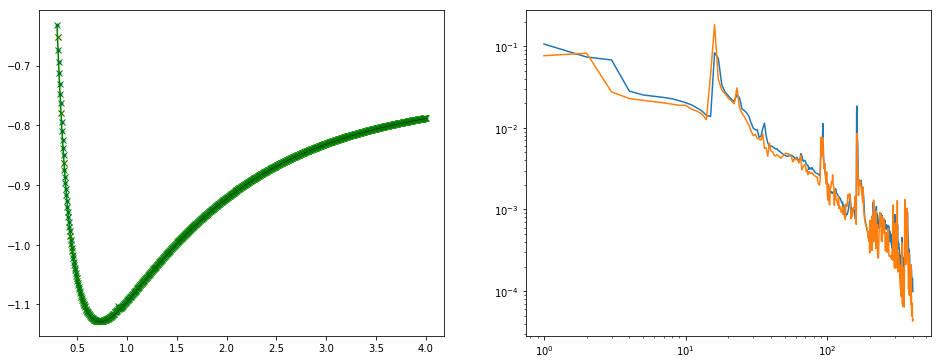

In [14]:
E_true = np.array([inp.Et for inp in inp_train]) 
E_val_true = np.array([inp.Et for inp in inp_valid])
R_tar = np.array([inp.molecule.R[1,0] for inp in inp_train])
R_prd = np.array([inp.molecule.R[1,0] for inp in inp_test])
#R_dense = np.array([inp.molecule.R[1,0] for inp in inp_dense])
R_val = np.array([inp.molecule.R[1,0] for inp in inp_valid])

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,6))
ax1.plot(R_tar, E_tar, ls='', marker='.')
ax1.plot(R_prd, E_prd, ls='', marker='x')
#ax1.plot(R_dense, E_dense, color='g')
ax1.plot(R_val, E_val, color='g', ls='', marker='x')
ax1.plot(R_val, E_val_true, color='g')
ax1.plot(R_tar, E_true, ls='', marker='.', color='k', markersize=0.2)
for i in [0,1]:
    ax2.loglog(opt_hist[i])

In [21]:
C_start = C_hist[1]
C_mid = C_hist[50]
C_end = C_hist[-1]

E_prd_start = []
E_prd_mid = []
E_prd_end = []
for i in range(len(inp_valid)):
    inp = inp_valid[i]
    Cs = C_start[i]
    Cm = C_mid[i]
    Ce = C_end[i]
    E_prd_start.append(qna.energy(inp, Cs))
    E_prd_mid.append(qna.energy(inp, Cm))
    E_prd_end.append(qna.energy(inp, Ce))
    
E_prd_start = np.array(E_prd_start)
E_prd_mid = np.array(E_prd_mid)
E_prd_end = np.array(E_prd_end)

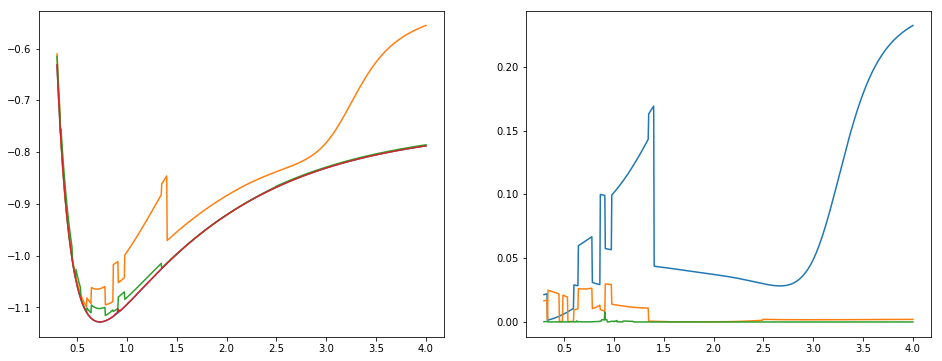

In [26]:
fig, [ax1, ax2]= plt.subplots(1,2, figsize=(16,6))

ax1.plot(R_val, E_val_true)
ax1.plot(R_val, E_prd_start)
ax1.plot(R_val, E_prd_mid)
ax1.plot(R_val, E_prd_end)

ax2.plot(R_val, abs(E_prd_start - E_val_true))
ax2.plot(R_val, abs(E_prd_mid - E_val_true))
ax2.plot(R_val, abs(E_prd_end - E_val_true))

In [17]:
test_hist = [0, 10, 20]
learn_E = learningCurve(qna.energy, inp_valid, C_hist, hist_ind=test_hist)
learn_eigs = learningCurve(qna.eigenvalues, inp_valid, C_hist, hist_ind=test_hist)
learn_fe = learningCurve(qna.fockError, inp_valid, C_hist, hist_ind=test_hist)
learn_drho = learningCurve(qna.dRho, inp_valid, C_hist, hist_ind=test_hist, diff=False)
learn_dpsi = learningCurve(qna.dPsi, inp_valid, C_hist, hist_ind=test_hist, diff=False)

In [19]:
print learn_E
print learn_eigs
print learn_fe
print learn_drho
print learn_dpsi

[0.12418897282536429, 0.020187448026088985, 0.023283253037005215]
[[ 0.08946519  0.13997526  0.15723478  0.17996137]
 [ 0.01495646  0.02473697  0.04675382  0.03509169]
 [ 0.00989694  0.03149726  0.05216778  0.02585762]]
[0.77471221984505811, 0.42171567090310097, 0.43931712526168532]
[1.2742204939209953, 0.33681008088646219, 0.32712925814873756]
[[ 14.36159926  32.4166398   37.56828704  25.58959473]
 [  5.0909238   31.5043623   19.63198934  15.16886482]
 [ 22.94370312  30.00591391  43.21096803  21.06491286]]


In [30]:
sample_step = 10
hist_x = range(len(opt_hist[2]))[::sample_step]

In [31]:
learn_E = learningCurve(qna.energy, inp_valid, C_hist, hist_ind=hist_x)

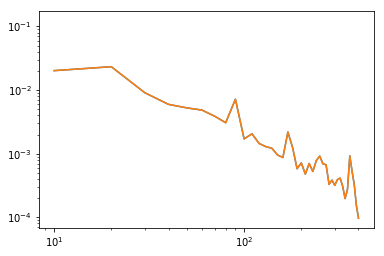

In [32]:
plt.loglog(hist_x, learn_E)
plt.loglog(hist_x, opt_hist[2][::sample_step])

In [34]:
#learn_eigs = learningCurve(eigenvalues, inp_valid, C_hist, hist_ind=hist_x)
learn_eigs = learningCurve(qna.eigenvalues, inp_valid, C_hist, hist_ind=hist_x)

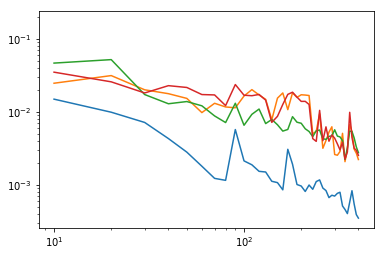

In [35]:
plt.loglog(hist_x, learn_eigs[:,0])
plt.loglog(hist_x, learn_eigs[:,1])
plt.loglog(hist_x, learn_eigs[:,2])
plt.loglog(hist_x, learn_eigs[:,3])

In [37]:
learn_fe = learningCurve(qna.fockError, inp_valid, C_hist, hist_ind=hist_x)

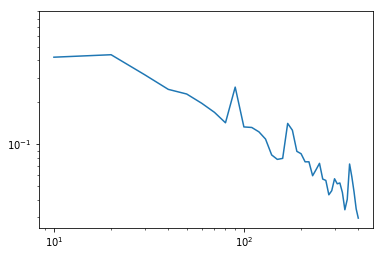

In [38]:
plt.loglog(hist_x, learn_fe)

In [44]:
learn_dme = learningCurve(qna.dmError, inp_valid, C_hist, hist_ind=hist_x, diff=False)

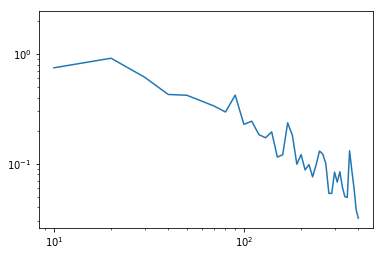

In [45]:
plt.loglog(hist_x, learn_dme)

In [40]:
learn_drho = learningCurve(qna.dRho, inp_valid, C_hist, hist_ind=hist_x, diff=False)

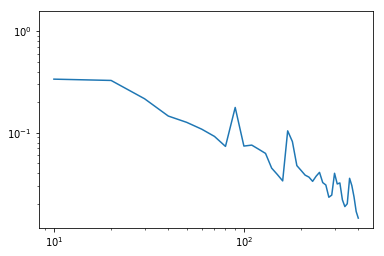

In [41]:
plt.loglog(hist_x, learn_drho)

In [47]:
learn_dpsi = learningCurve(qna.dPsi, inp_valid, C_hist, hist_ind=hist_x, diff=False)

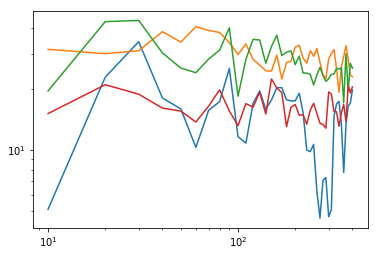

In [49]:
for i in range(4):
    plt.loglog(hist_x, learn_dpsi[:,i])